In [1]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf


In [2]:
def double_conv_block(x, n_filters):
    # Функция создаёт 2 сверточных слоя подряд с активацией ReLU.
    # Это типичная часть нейросетей, особенно в обработке изображений (например, в U-Net).

    # Первый сверточный слой:
    # - n_filters — количество фильтров (то есть, сколько признаков будет извлекаться)
    # - 3 — размер фильтра 3x3
    # - padding="same" — сохраняет размер изображения таким же (добавляет рамку, если нужно)
    # - activation="relu" — ReLU-функция активации, добавляет "нелинейность", помогает обучению
    # - kernel_initializer="he_normal" — способ начальной настройки весов (полезно при ReLU)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Второй сверточный слой — такой же, как первый
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Возвращаем результат — теперь это "обработанное изображение"
    return x


In [3]:
def downsample_block(x, n_filters):
    # Создаёт блок для уменьшения размера изображения (downsampling).
    # x — входной тензор (например, изображение)
    # n_filters — сколько признаков (фильтров) извлекать

    # Сначала применяем двойной свёрточный блок (из предыдущего шага),
    # он помогает извлечь важные признаки из изображения.
    f = double_conv_block(x, n_filters)

    # Затем уменьшаем размер изображения в 2 раза (по ширине и высоте),
    # но сохраняем только важную информацию — это делает обучение быстрее.
    # MaxPool2D(2) — берёт максимум из каждого квадратика 2x2
    p = layers.MaxPool2D(2)(f)

    # Применяем Dropout — случайно "выключаем" 30% нейронов,
    # чтобы избежать переобучения (то есть, модель не запомнит, а именно научится).
    p = layers.Dropout(0.3)(p)

    # Возвращаем оба результата:
    # f — признаки до уменьшения размера (часто нужны потом при объединении),
    # p — уменьшенный по размеру результат, с которым дальше будет работать сеть
    return f, p


In [4]:
def upsample_block(x, conv_features, n_filters):
    # Эта функция делает "обратное" сжатие — увеличивает размер изображения (upsampling)
    # x — текущее сжатое изображение
    # conv_features — признаки с соответствующего уровня downsampling (для объединения)
    # n_filters — сколько фильтров (признаков) использовать

    # 1. Увеличиваем размер изображения в 2 раза:
    # Conv2DTranspose — "обратная свёртка", которая растягивает картинку
    # 3 — размер ядра 3x3, 2 — шаг в 2 пикселя, padding="same" — сохранить размер
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

    # 2. Объединяем увеличенное изображение с признаками из "нисходящего" пути сети
    # Это помогает восстановить детали, которые могли быть потеряны при сжатии
    x = layers.concatenate([x, conv_features])

    # 3. Dropout — случайно отключаем 30% нейронов для защиты от переобучения
    x = layers.Dropout(0.3)(x)

    # 4. Пропускаем через два свёрточных слоя с активацией ReLU (как в double_conv_block)
    x = double_conv_block(x, n_filters)

    # 5. Возвращаем результат
    return x


In [5]:
def build_unet_model(num_classes):
    # Входной слой. Ожидаем изображение 160x160 пикселей с 3 каналами (RGB)
    inputs = layers.Input(shape=(160, 160, 3))

    # === ЭНКОДЕР: сжатие и извлечение признаков ===
    # 1. Первая понижающая свёртка (64 фильтра)
    f1, p1 = downsample_block(inputs, 64)

    # 2. Вторая понижающая свёртка (128 фильтров)
    f2, p2 = downsample_block(p1, 128)

    # 3. Третья понижающая свёртка (256 фильтров)
    f3, p3 = downsample_block(p2, 256)

    # 4. Четвёртая понижающая свёртка (512 фильтров)
    f4, p4 = downsample_block(p3, 512)

    # === Бутылочное горлышко: "дно" U-сети ===
    bottleneck = double_conv_block(p4, 1024)

    # === ДЕКОДЕР: восстановление изображения (повышение дискретизации) ===
    # 6. Поднимаемся вверх, объединяя с f4
    u6 = upsample_block(bottleneck, f4, 512)

    # 7. Объединяем с f3
    u7 = upsample_block(u6, f3, 256)

    # 8. Объединяем с f2
    u8 = upsample_block(u7, f2, 128)

    # 9. Объединяем с f1
    u9 = upsample_block(u8, f1, 64)

    # === ВЫХОДНОЙ СЛОЙ: классификация каждого пикселя ===
    # Применяем свёртку с количеством каналов = числу классов
    # softmax делает выход — вероятностным (для сегментации)
    outputs = layers.Conv2D(num_classes, 3, padding="same", activation="softmax")(u9)

    # Сборка модели
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model


In [7]:
# Создаём U-Net модель для 3 классов (например: фон, орган, опухоль)
unet_model = build_unet_model(3)

# Компилируем модель перед обучением:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Оптимизатор Adam — современный и надёжный
    loss="sparse_categorical_crossentropy",  # Функция потерь — для многоклассовой классификации
    metrics=["accuracy"]  # Показываем точность (долю правильно угаданных пикселей)
)


In [8]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 160, 160,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 160, 160,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 80, 80,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 80, 80,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 80, 80,    │     73,856 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 80, 80,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 40, 40,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 40, 40,    │          0 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 40, 40,    │    295,168 │ dropout_9[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 40, 40,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 20, 20,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 20, 20,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 20, 20,    │  1,180,160 │ dropout_10[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 20, 20,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 10, 10,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 10, 10,    │          0 │ max_pooling2d_7[

 Total params: 34,515,011 (131.66 MB)

 Trainable params: 34,515,011 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Импортируем модуль utils из библиотеки Keras
# Этот модуль содержит полезные инструменты для работы с нейросетями
import keras.utils

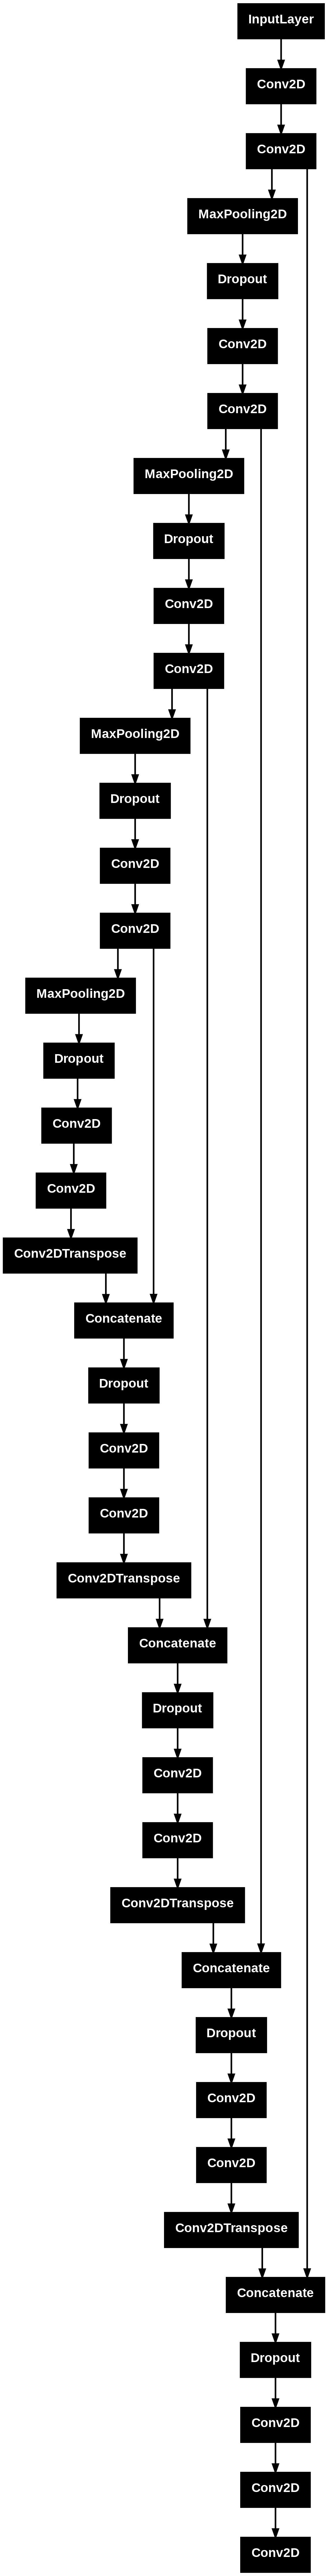

In [11]:
# Строим визуализацию архитектуры модели
# Это создаст картинку-схему, где видно, какие слои в модели, как они соединены и какие у них выходные размеры
keras.utils.plot_model(
    unet_model)        # Модель, которую хотим изобразить (в нашем случае — U-Net

#Скачиваем данные

In [18]:
# Удаляем старые версии архивов, если они уже есть — чтобы не было дубликатов типа .tar.gz.1
!rm -f images.tar.gz annotations.tar.gz

# Скачиваем архив с изображениями домашних животных (кошки/собаки)
!wget https://thor.robots.ox.ac.uk/pets/images.tar.gz

# Скачиваем архив с аннотациями (масками и метками для сегментации)
!wget https://thor.robots.ox.ac.uk/pets/annotations.tar.gz

# Проверяем, что файлы действительно скачались
!ls -lh images.tar.gz annotations.tar.gz

# Распаковываем архив с изображениями
# -x  — извлечь содержимое
# -f  — указать имя архива
!tar -xf images.tar.gz

# Распаковываем архив с аннотациями (включает маски сегментации)
!tar -xf annotations.tar.gz

# Проверим, что внутри — убедимся, что папки появились
!ls images | head         # Показываем первые 10 файлов в папке с изображениями
!ls annotations | head    # Показываем содержимое папки с аннотациями


--2025-06-06 07:43:56--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  20.6MB/s    in 41s     

2025-06-06 07:44:37 (18.5 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-06-06 07:44:37--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  13.9MB/s    in 1.3s    

2025-06-06 07:44:39 (13.9 MB/s)

Подготовим пути входных изображений и целевые маски сегментации

In [19]:
import os

In [20]:
input_dir = "images/"              # Папка, где хранятся входные изображения (фото кошек и собак)
target_dir = "annotations/trimaps/" # Папка, где хранятся маски сегментации (целевые изображения)

img_size = (160, 160)  # Размер, до которого будут уменьшены все изображения
num_classes = 3        # Количество классов: фон, животное, граница
batch_size = 2         # Размер пакета данных для обучения — по 2 изображения за раз

# Собираем пути ко всем .jpg файлам из папки с изображениями
input_img_paths = sorted(
    [os.path.join(input_dir, fname)            # Объединяем путь и имя файла
     for fname in os.listdir(input_dir)        # Перебираем все файлы в папке изображений
     if fname.endswith(".jpg")]                # Оставляем только те, что заканчиваются на ".jpg"
)

# Собираем пути ко всем .png маскам из папки с масками
target_img_paths = sorted(
    [os.path.join(target_dir, fname)                  # Объединяем путь и имя файла
     for fname in os.listdir(target_dir)              # Перебираем все файлы в папке масок
     if fname.endswith(".png") and not fname.startswith(".")]  # Только .png и не скрытые файлы
)

# Печатаем общее количество пар (вход + маска)
print("Number of samples:", len(input_img_paths))

# Показываем первые 10 пар: путь к изображению и путь к маске
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [21]:
# Импортируем функции Image и display из модуля IPython.display
# Они позволяют красиво выводить изображения прямо в Jupyter/Colab
from IPython.display import Image, display

# Импортируем функцию load_img из Keras — она позволяет удобно загружать изображения с диска
from keras.utils import load_img

# Импортируем ImageOps из библиотеки PIL (Python Imaging Library)
# Это даёт доступ к дополнительным операциям над изображениями (например, обрезка, инвертирование, рамки)
from PIL import ImageOps


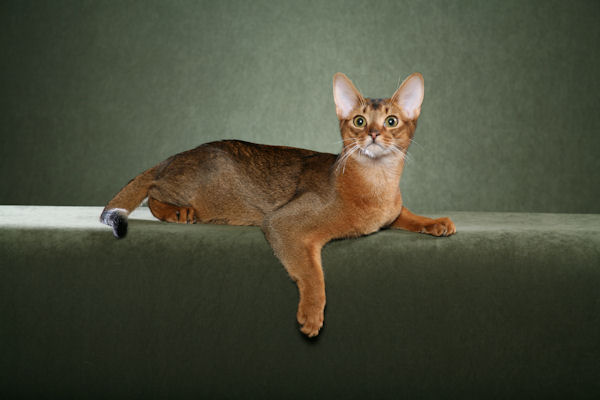

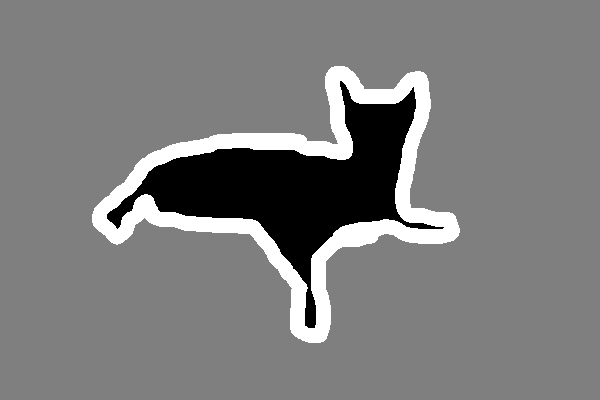

In [22]:
# отображаем самый первый рисунок и маску
display(Image(filename=input_img_paths[0]))
# input_img_paths — список путей к изображениям (например, 'images/Abyssinian_1.jpg')
# input_img_paths[0] — берёт первое изображение из списка
# Image(...) — создаёт объект изображения по пути к файлу
# display(...) — выводит картинку прямо в ячейке ноутбука (Jupyter или Google Colab)

# Отображение версии автоконтрастности соответствующей цели (попиксельные категории)
img = ImageOps.autocontrast(load_img(target_img_paths[0]))
# target_img_paths[0] — путь к первой маске сегментации (например, 'annotations/trimaps/Abyssinian_1.png')
# load_img(...) — загружает маску как изображение
# ImageOps.autocontrast(...) — делает изображение более видимым, улучшая контраст (маска может быть тусклой)

display(img)
# Выводим обработанную маску


In [23]:
  # Импортируем модуль data из TensorFlow и называем его tf_data
# tf_data используется для создания эффективных пайплайнов обработки данных (например, загрузка, преобразование, пакетирование)
from tensorflow import data as tf_data

# Импортируем модуль image из TensorFlow и называем его tf_image
# tf_image содержит функции для обработки изображений (изменение размера, нормализация, аугментации и др.)
from tensorflow import image as tf_image

# Импортируем модуль io из TensorFlow и называем его tf_io
# tf_io используется для операций ввода-вывода, таких как чтение изображений с диска в формате TensorFlow
from tensorflow import io as tf_io


In [24]:
# Функция get_dataset создаёт готовый объект tf.data.Dataset для подачи изображений и масок в нейросеть
def get_dataset(
    batch_size,         # Размер пакета (batch) — сколько картинок загружать одновременно
    img_size,           # Размер изображений после изменения (например, (160, 160))
    input_img_paths,    # Список путей к входным изображениям
    target_img_paths,   # Список путей к маскам сегментации
    max_dataset_len=None # Максимальное количество пар для загрузки (для отладки)
):

    """Возвращает набор данных TF."""

    # Вложенная функция, загружает одно изображение и маску по путям
    def load_img_masks(input_img_path, target_img_path):
        # Загружаем входное изображение
        input_img = tf_io.read_file(input_img_path)                     # Чтение файла в виде байтов
        input_img = tf_image.decode_png(input_img, channels=3)         # Декодируем как RGB изображение
        input_img = tf_image.resize(input_img, img_size)               # Изменяем размер до нужного
        input_img = tf_image.convert_image_dtype(input_img, "float32") # Преобразуем к типу float32 (значения от 0 до 1)

        # Загружаем соответствующую маску сегментации
        target_img = tf_io.read_file(target_img_path)                        # Чтение файла
        target_img = tf_image.decode_png(target_img, channels=1)            # Маска — 1-канальное изображение (ч/б)
        target_img = tf_image.resize(target_img, img_size, method="nearest")# Изменяем размер (метод "nearest" сохраняет классы)
        target_img = tf_image.convert_image_dtype(target_img, "uint8")      # Преобразуем к целым числам

        # Метки в масках — это 1, 2, 3 (фон, животное, граница).
        # Чтобы получить метки 0, 1, 2 — вычитаем 1
        target_img -= 1

        # Возвращаем пару: входное изображение и соответствующая маска
        return input_img, target_img

    # Если задано ограничение на количество образцов — обрезаем списки
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]

    # Создаём объект tf.data.Dataset из пар путей (input_path, target_path)
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))

    # Преобразуем каждую пару путей в (изображение, маска)
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)

    # Разбиваем набор данных на пакеты по batch_size и возвращаем
    return dataset.batch(batch_size)


In [26]:
import random
limit=10

In [27]:
# Разделите наши пути img на обучающий и проверочный (валидационный) набор.
val_samples = limit  # Количество изображений, выделенных на валидацию (переменная limit задана ранее)

# Перемешиваем пути к изображениям и маскам одинаково, чтобы сохранить соответствие
random.Random(1337).shuffle(input_img_paths)   # Перемешиваем пути к входным изображениям
random.Random(1337).shuffle(target_img_paths)  # Перемешиваем пути к маскам сегментации

# Разделяем данные на обучающую и проверочную части
# Всё, кроме последних val_samples → обучение
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

# Последние val_samples → валидация
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создаём экземпляр набора данных для обучения
# max_dataset_len ограничивает количество данных (удобно при отладке)
train_dataset = get_dataset(
    batch_size,               # Размер пакета (например, 2)
    img_size,                 # Размер изображения (например, (160, 160))
    train_input_img_paths,    # Пути к обучающим изображениям
    train_target_img_paths,   # Пути к маскам для обучения
    max_dataset_len=limit     # Ограничиваем количество (для ускорения)
)

# Создаём экземпляр набора данных для валидации (проверки)
valid_dataset = get_dataset(
    batch_size,
    img_size,
    val_input_img_paths,      # Пути к проверочным изображениям
    val_target_img_paths      # Пути к маскам для валидации
    # max_dataset_len не указывается, берутся все val_samples
)


In [28]:
import sys
# Импортируем стандартный модуль sys — он содержит функции для работы с объектами на уровне Python-интерпретатора

# Пытаемся получить размер загружаемого изображения (в байтах)
sys.getsizeof(tf_io.read_file(train_input_img_paths[0]))
# tf_io.read_file(...) — читает файл (изображение) и возвращает его как Tensor (байтовая строка)
# train_input_img_paths[0] — путь к первому обучающему изображению
# sys.getsizeof(...) — пытается измерить, сколько байт занимает этот объект в памяти


184

In [29]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None))>

In [30]:
sys.getsizeof(train_dataset)


56

In [31]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [32]:
epochs = 15
# Количество эпох обучения — сколько раз модель пройдёт весь обучающий набор данных

unet_model.fit(
    train_dataset,               # Обучающий датасет (в формате tf.data.Dataset)
    epochs=epochs,               # Количество эпох
    validation_data=valid_dataset,  # Валидационный датасет (для оценки качества после каждой эпохи)
    verbose=2                    # Уровень вывода информации:
                                 # 0 — ничего не показывать,
                                 # 1 — прогресс в виде полоски,
                                 # 2 — текстовая строка по эпохам (рекомендуется в Colab)
)


Epoch 1/15
5/5 - 52s - 10s/step - accuracy: 0.4572 - loss: 96.7683 - val_accuracy: 0.5390 - val_loss: 19.2887
Epoch 2/15
5/5 - 90s - 18s/step - accuracy: 0.4663 - loss: 18.0683 - val_accuracy: 0.4631 - val_loss: 4.1899
Epoch 3/15
5/5 - 71s - 14s/step - accuracy: 0.5404 - loss: 7.0065 - val_accuracy: 0.4405 - val_loss: 2.4933
Epoch 4/15
5/5 - 41s - 8s/step - accuracy: 0.4901 - loss: 3.9513 - val_accuracy: 0.5263 - val_loss: 2.1187
Epoch 5/15
5/5 - 81s - 16s/step - accuracy: 0.5521 - loss: 2.3302 - val_accuracy: 0.4849 - val_loss: 1.3527
Epoch 6/15
5/5 - 44s - 9s/step - accuracy: 0.5261 - loss: 1.6180 - val_accuracy: 0.4405 - val_loss: 1.2705
Epoch 7/15
5/5 - 79s - 16s/step - accuracy: 0.5502 - loss: 1.3219 - val_accuracy: 0.4957 - val_loss: 1.1736
Epoch 8/15
5/5 - 43s - 9s/step - accuracy: 0.5839 - loss: 1.1683 - val_accuracy: 0.5211 - val_loss: 1.1239
Epoch 9/15
5/5 - 79s - 16s/step - accuracy: 0.5993 - loss: 1.0865 - val_accuracy: 0.5268 - val_loss: 1.0947
Epoch 10/15
5/5 - 41s - 8s/s

In [33]:
from PIL import Image as Im
# Импортируем класс Image из библиотеки PIL (Python Imaging Library)
# Переименовываем его как Im — для краткости в коде


In [34]:


def display_mask(i):
    """Быстрая утилита для отображения прогноза модели"""

    # val_preds — это результат предсказания модели (например, model.predict(...))
    # np.argmax(..., axis=-1) — для каждого пикселя выбираем класс с наибольшей вероятностью
    mask = np.argmax(val_preds[i], axis=-1)

    # Добавляем дополнительную ось (канал), чтобы маску можно было превратить в изображение
    mask = np.expand_dims(mask, axis=-1)

    # Преобразуем маску в изображение и автоматически усиливаем контраст
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))

    # Изменяем размер изображения до 500x500 с фильтром сглаживания LANCZOS (высокое качество)
    img = img.resize((500, 500), Im.LANCZOS)

    # Показываем изображение внутри ноутбука (Jupyter или Colab)
    display(img)


In [35]:
def check_one_image(i):
    # Отображение входного изображения (оригинального фото из валидационного набора)
    display(Image(filename=val_input_img_paths[i]))
    # val_input_img_paths[i] — путь к i-му изображению
    # Image(...) — создаёт объект изображения по пути
    # display(...) — выводит его в ноутбуке

    # Отображение истинной маски (разметки, созданной человеком)
    img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
    # Загружаем маску (разметку) и усиливаем контрастность — для наглядности
    display(img)

    # Отображение предсказанной маски (то, что "решила" модель)
    display_mask(i)
    # Используется функция, которую мы рассматривали ранее


In [36]:
val_preds = unet_model.predict(valid_dataset)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


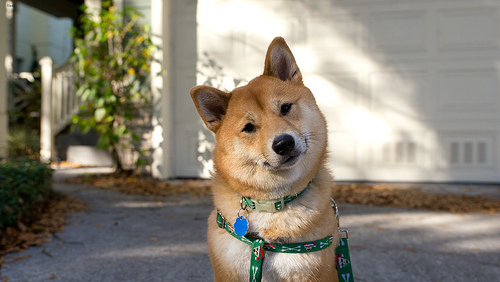

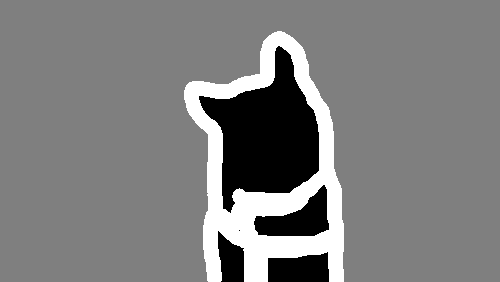

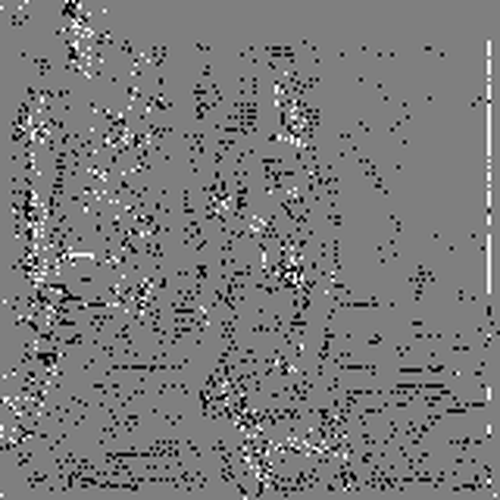

In [37]:
check_one_image(0)


# Второй вариант с одной эпохой и всеми примерами

In [38]:
# Создаём собственный генератор данных, совместимый с Keras
class OxfordPets(keras.utils.Sequence):
    """Вспомогательный класс для итерации по данным в формате Numpy."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        # Сохраняем параметры и списки путей к данным
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        # Возвращает количество пакетов (batch'ей) в датасете
        # целочисленное деление общего числа масок на размер пакета
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Возвращает один пакет (вход, маска) с индексом idx."""

        # Вычисляем индекс первого элемента пакета
        i = idx * self.batch_size

        # Получаем списки путей к изображениям и маскам в этом пакете
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]

        # Создаём пустой массив для изображений: (batch_size, высота, ширина, 3 канала)
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype='float32')

        # Загружаем и вставляем каждое изображение
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)  # Загружаем изображение
            x[j] = img                                         # Кладём его в массив

        # Создаём массив для масок: (batch_size, высота, ширина, 1 канал)
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype='uint8')

        # Загружаем и вставляем каждую маску
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)  # Добавляем размерность канала

        # Возвращаем пару: изображения и соответствующие маски
        return x, y


#Пробуем различные loss функции

In [40]:
!pip install segmentation_models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [41]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
# Указываем библиотеке segmentation_models использовать TensorFlow Keras как backend

from tensorflow import keras
# Импортируем keras-модуль из TensorFlow (например, для .fit, .Model и т.п.)

import segmentation_models as sm
# Импортируем библиотеку готовых моделей сегментации: U-Net, FPN, PSPNet и др.
# Подключает архитектуры с популярными энкодерами (ResNet, EfficientNet и т.д.)


Segmentation Models: using `tf.keras` framework.


In [42]:
# Импортируем функции потерь из библиотеки segmentation_models
dice_loss = sm.losses.DiceLoss()                       # Dice Loss — хорошо работает при несбалансированных классах
focal_loss = sm.losses.CategoricalFocalLoss()          # Focal Loss — помогает модели сосредоточиться на сложных примерах

# Комбинируем обе функции потерь
total_loss = dice_loss + (1 * focal_loss)              # Можно менять коэффициент перед focal_loss (например, 0.5 или 2)


In [43]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Возвращает набор данных TF (tf.data.Dataset)"""

    # Функция загрузки одного изображения и соответствующей маски
    def load_img_masks(input_img_path, target_img_path):
        # Загружаем и обрабатываем входное изображение
        input_img = tf_io.read_file(input_img_path)                         # Чтение файла
        input_img = tf_image.decode_png(input_img, channels=3)             # Распаковка PNG, RGB-формат
        input_img = tf_image.resize(input_img, img_size)                   # Изменение размера
        input_img = tf_image.convert_image_dtype(input_img, "float32")     # Перевод в формат float32 (0...1)

        # Загружаем и обрабатываем маску (разметку)
        target_img = tf_io.read_file(target_img_path)                      # Чтение файла
        target_img = tf_image.decode_png(target_img, channels=1)           # Одноканальное изображение (черно-белое)
        target_img = tf_image.resize(target_img, img_size, method="nearest") # resize без интерполяции
        target_img = tf_image.convert_image_dtype(target_img, "float32")   # Преобразуем в float (или лучше — в uint8)

        # Маска содержит классы 1, 2, 3. Вычитаем 1, чтобы получить 0, 1, 2
        target_img -= 1

        return input_img, target_img

    # Для отладки можно ограничить число примеров (например, 100)
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]

    # Создаём TensorFlow Dataset из списков путей
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))

    # Применяем функцию загрузки изображений к каждому элементу
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)

    # Группируем по пакетам и возвращаем
    return dataset.batch(batch_size)
